# Unit 20.3.2 - Craft a Story from a Dataset - Anime Recommendations

In this assignment, we will look at an anime recommendations dataset and visualize the data. The data cleaning and visualization are done in this notebook, but the final slide presentation can be found in these google slides: [https://docs.google.com/presentation/d/1Pfvh9p9qzhoUpBjIYUH5jx86bwgniU6mr4SlUrz5tK8/edit?usp=sharing]

The dataset used is the following: https://www.kaggle.com/CooperUnion/anime-recommendations-database

## Intro

Let's say you're a anime production company, and you want to make the next big hit. You're trying to figure out whether you should make a movie or a tv series. If you make a tv series, you want to know whether to keep it short and sweet (13 or 24 episode run) or go for the long run (aiming for the thousands of episodes). 

You take a look at the kaggle dataset for anime recommendations scraped from user entries on myanimelist.net, and you notice there are two obvious ways to determine the success of an anime: rating and members. By looking at the most highly rated series, you can find the ingredients to make the next award-winning-level anime. And by looking at the animes with the most members, we can see what types of animes become popular.

With this goal in mind, let's explore the data!

In [1]:
# import packages

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [2]:
path = 'data'
os.chdir(path)

In [3]:
#load the data
anime = pd.read_csv("anime.csv")
rating = pd.read_csv("rating.csv")

Let's examine the data and do some basic cleaning.

## Data Cleaning and Wrangling

In [4]:
#take a look at the data
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [5]:
anime.info()
#Looks like some anime are missing a rating, genre, or type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [6]:
#Which columns are missing the most info?
anime[anime.isna().any(axis=1)].info()

#It looks like of the 277 series missing information, most are missing the rating.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277 entries, 2844 to 12285
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  277 non-null    int64  
 1   name      277 non-null    object 
 2   genre     215 non-null    object 
 3   type      252 non-null    object 
 4   episodes  277 non-null    object 
 5   rating    47 non-null     float64
 6   members   277 non-null    int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 17.3+ KB


In [7]:
#Let's go ahead and drop the anime series with missing data
anime = anime.dropna()
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12017 non-null  int64  
 1   name      12017 non-null  object 
 2   genre     12017 non-null  object 
 3   type      12017 non-null  object 
 4   episodes  12017 non-null  object 
 5   rating    12017 non-null  float64
 6   members   12017 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 751.1+ KB


In [8]:
#We see that name, genre, type, and episodes are non-numerical. 
#Episodes should be turned into an int, name can be ignored (it's essentially a unique value)
#and genre & type can be one-hot encoded using the pandas get_dummies method.

#Let's deal with episodes first.

#anime.episodes.unique() #there is one value, "Unknown" that is a string
anime[anime.episodes == 'Unknown'].head()
#There are a number of series with "Unknown" number of episodes, likely because they are ongoing series. 

anime = anime.replace('Unknown', np.nan) # replace "Unknown" with NaN
anime = anime.astype({'episodes': 'float64'}) #convert the episodes column to float
anime.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes    float64
rating      float64
members       int64
dtype: object

In [9]:
#Next let's one-hot encode the 'genre' column

len(anime.genre.unique()) #There are 3229 unique values. Many of these are multiple genres separated by ', '
#genre_dummies = anime['genre'].str.get_dummies(sep=', ').add_prefix('genre_') #add a prefix
genre_dummies = anime['genre'].str.get_dummies(sep=', ') #don't add a prefix
anime_genre_split = anime.drop(columns=['genre']).join(genre_dummies)
anime_genre_split.head()

,anime_id,name,type,episodes,rating,members,Action,Adventure,Cars,Comedy,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,32281,Kimi no Na wa.,Movie,1.0,9.37,200630,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,TV,64.0,9.26,793665,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,28977,Gintama°,TV,51.0,9.25,114262,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,9253,Steins;Gate,TV,24.0,9.17,673572,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,9969,Gintama&#039;,TV,51.0,9.16,151266,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
anime_genre_split.info() #Looks like only "name" and "type" are the only non-numerical columns left

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017 entries, 0 to 12293
Data columns (total 49 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   anime_id       12017 non-null  int64  
 1   name           12017 non-null  object 
 2   type           12017 non-null  object 
 3   episodes       11830 non-null  float64
 4   rating         12017 non-null  float64
 5   members        12017 non-null  int64  
 6   Action         12017 non-null  int64  
 7   Adventure      12017 non-null  int64  
 8   Cars           12017 non-null  int64  
 9   Comedy         12017 non-null  int64  
 10  Dementia       12017 non-null  int64  
 11  Demons         12017 non-null  int64  
 12  Drama          12017 non-null  int64  
 13  Ecchi          12017 non-null  int64  
 14  Fantasy        12017 non-null  int64  
 15  Game           12017 non-null  int64  
 16  Harem          12017 non-null  int64  
 17  Hentai         12017 non-null  int64  
 18  Histor

In [11]:
#Next let's one-hot encode the 'type' column
len(anime_genre_split.type.unique()) #There are 6 unique values.
anime_genre_split.type.unique() #['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA']

type_dummies = anime_genre_split['type'].str.get_dummies().add_prefix('type_') #add a prefix
#type_dummies = anime_genre_split['type'].str.get_dummies() #don't add prefix
anime_clean = anime_genre_split.drop(columns=['type']).join(type_dummies)
anime_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017 entries, 0 to 12293
Data columns (total 54 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   anime_id       12017 non-null  int64  
 1   name           12017 non-null  object 
 2   episodes       11830 non-null  float64
 3   rating         12017 non-null  float64
 4   members        12017 non-null  int64  
 5   Action         12017 non-null  int64  
 6   Adventure      12017 non-null  int64  
 7   Cars           12017 non-null  int64  
 8   Comedy         12017 non-null  int64  
 9   Dementia       12017 non-null  int64  
 10  Demons         12017 non-null  int64  
 11  Drama          12017 non-null  int64  
 12  Ecchi          12017 non-null  int64  
 13  Fantasy        12017 non-null  int64  
 14  Game           12017 non-null  int64  
 15  Harem          12017 non-null  int64  
 16  Hentai         12017 non-null  int64  
 17  Historical     12017 non-null  int64  
 18  Horror

We've finished preparing the "anime" df with a "anime_clean" df that can be used for some modeling. Now let's look at the "ratings" df.

In [12]:
# note, -1 value is given when no rating is given
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [13]:
rating.nunique()
#This tells us we have 73,515 users, 11,200 unique animes, and 11 rating (rating from 1-10, and no rating)
#11200 is less than 12017 anime id's we have, implying that not all the entries in the anime df is represented
#in the ratings df.

user_id     73515
anime_id    11200
rating         11
dtype: int64

In [14]:
#How many entries had no ratings? How many had ratings?
no_rating = len(rating[rating.rating == -1])
has_rating = len(rating) - no_rating
print('There are',no_rating,'entries without ratings.')
print('There are',has_rating,'entries with ratings.')

There are 1476496 entries without ratings.
There are 6337241 entries with ratings.


In [15]:
#let's bifurcate the data so we can see what trends exist amongst the data that was rated
#and what patterns we can find in the unrated anime.

#first, pandas merge the anime df to the user ratings df
rating_renamed = rating.rename(columns = {'rating': 'user_rating'})
rating_expanded = pd.merge(rating_renamed, anime_clean, how='left', on='anime_id')
rating_expanded.head()

,user_id,anime_id,user_rating,name,episodes,rating,members,Action,Adventure,Cars,...,Thriller,Vampire,Yaoi,Yuri,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV
0,1,20,-1,Naruto,220.0,7.81,683297.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,24,-1,School Rumble,26.0,8.06,178553.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,79,-1,Shuffle!,24.0,7.31,158772.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,226,-1,Elfen Lied,13.0,7.85,623511.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,241,-1,Girls Bravo: First Season,11.0,6.69,84395.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
#now bifurcate the data
no_rating = rating_expanded[rating_expanded.rating == -1]
has_rating = rating_expanded[rating_expanded.rating != -1]

At this point, we have the following dataframes we can work with:
1. "anime" df - our original df with all NaN values dropped
2. "anime_clean" df - all columns aside from "name" were one-hot encoded or made into numerical values
3. "no_rating" df - all the user entries that don't have a rating assigned. Merged with "anime_clean".
4. "has_rating" df - all the user entries that have a valid rating (from 1 to 10). Merged with "anime_clean".

Let's start visualizing.

## Data Visualization

C:\Users\grace\anaconda3\envs\TestEnv7\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\grace\anaconda3\envs\TestEnv7\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


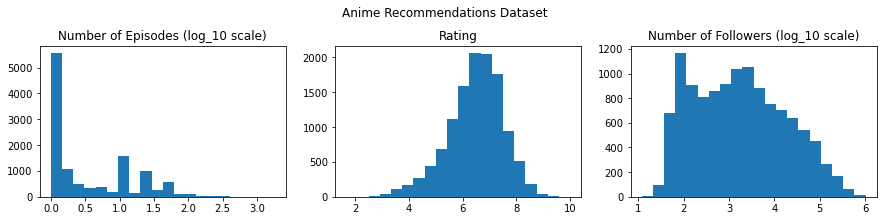

In [17]:
#First let's see the distributions of the numerical values ['episodes', 'rating', 'members']
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(15,3))
_=fig.suptitle('Anime Recommendations Dataset')
_=fig.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.8, wspace=0.2, hspace=0.5)
_=ax1.hist(np.log10(anime.episodes), bins=20)
_=ax1.set_title('Number of Episodes (log_10 scale)')
_=ax2.hist(anime.rating, bins=20)
_=ax2.set_title('Rating')
_=ax3.hist(np.log10(anime.members), bins=20)
_=ax3.set_title('Number of Followers (log_10 scale)')

We see that most animes seem to end in one season, though there are some that have episodes in the thousands (10^3). 

We also see that the ratings are skewed left, with the mode rating around a 7. 

Finally, we see that many animes have hundreds to thousands of followers, though some have as few as on the order of 10 followers while others have up to the millions.

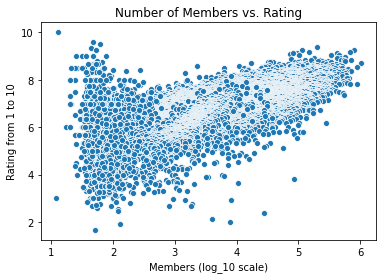

In [18]:
#Next let's look at our 2 important variables: rating and members. We expect them to be correlated. Are they?

_=sns.scatterplot(np.log10(anime.members), anime.rating)
_=plt.title('Number of Members vs. Rating')
_=plt.xlabel('Members (log_10 scale)')
_=plt.ylabel('Rating from 1 to 10')

#As the number of members increases, the ratings do seem to trend upwards.

From our scatterplot, we see that as the number of members increases (i.e. the anime becomes more popular), the ratings do seem to trend upwards. However, there are some series with many members (on order of 10k) that have fairly low ratings. That's something to keep an eye out for. Popularity does not always equal high ratings.

### The top 5% (Highest Rated)

Let's take a look at the top 5% most highly rated series and see how they're distributed by genre,type, and number of episodes.

In [19]:
n = 5
anime_sorted = anime_clean.sort_values(by='rating', ascending=False)
top_5 = anime_sorted.head(int(len(anime_sorted)*(n/100))).drop(columns=['anime_id','name'])

In [20]:
col_genre = ['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi',
       'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical', 'Horror', 'Josei',
       'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music',
       'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai',
       'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen',
       'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power',
       'Supernatural', 'Thriller', 'Vampire', 'Yaoi', 'Yuri'] 

col_type = ['type_Movie', 'type_Music', 'type_ONA', 'type_OVA', 'type_Special', 'type_TV']

In [21]:
#Let's get the total number of each genre and type
sum_top_5 = top_5.sum(axis=0)
sum_top_5

episodes            10601.0
rating               4996.5
members          73306277.0
Action                199.0
Adventure             127.0
Cars                    7.0
Comedy                255.0
Dementia                4.0
Demons                 19.0
Drama                 233.0
Ecchi                   8.0
Fantasy               122.0
Game                   13.0
Harem                   6.0
Hentai                  1.0
Historical             80.0
Horror                 18.0
Josei                  14.0
Kids                   46.0
Magic                  33.0
Martial Arts           13.0
Mecha                  33.0
Military               35.0
Music                  21.0
Mystery                91.0
Parody                 26.0
Police                 23.0
Psychological          49.0
Romance               127.0
Samurai                21.0
School                 95.0
Sci-Fi                 98.0
Seinen                 60.0
Shoujo                 34.0
Shoujo Ai               1.0
Shounen             

In [22]:
#Genre
genre_top_5 = sum_top_5[col_genre].sort_values(ascending=True)

#Type
type_top_5 = sum_top_5[col_type].sort_values(ascending=False)

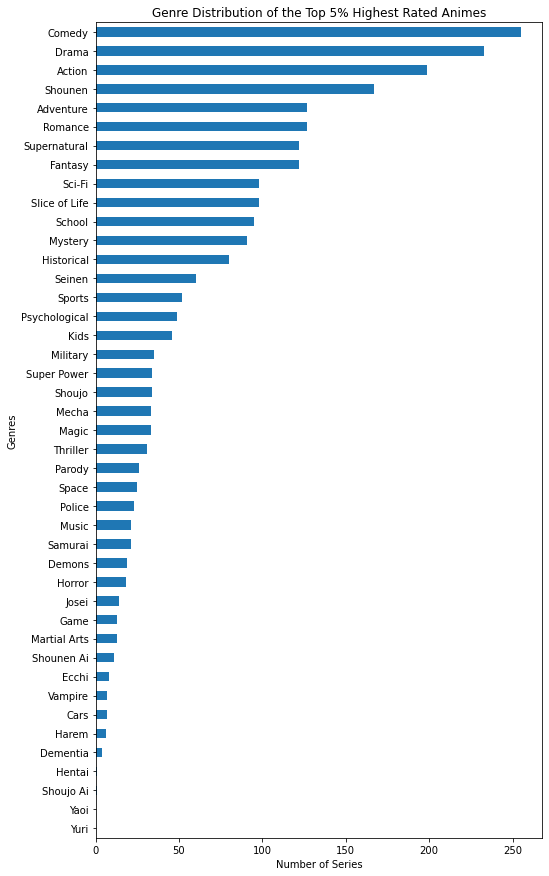

In [23]:
fig = plt.subplots(figsize=(8,15))
_=genre_top_5.plot(kind='barh')
_=plt.title('Genre Distribution of the Top 5% Highest Rated Animes')
_=plt.ylabel('Genres')
_=plt.xlabel('Number of Series')

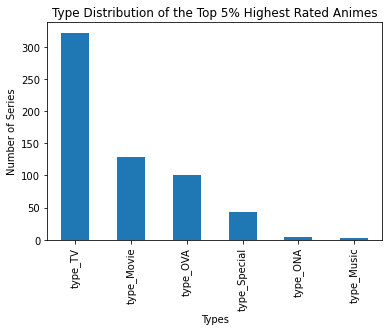

In [24]:
_=type_top_5.plot(kind='bar')
_=plt.title('Type Distribution of the Top 5% Highest Rated Animes')
_=plt.xlabel('Types')
_=plt.ylabel('Number of Series')

We know to get a highly rated anime, we need to make a TV series that has the genres of Comedy, Drama, Action, or Shounen. Adventure, Romance, Supernatural, and Fantasy follow closely after, so it would be fine to mix some of those in as well.

Since we're aiming for a TV series, let's take a look at wether to have a short 1-season series or something longer.

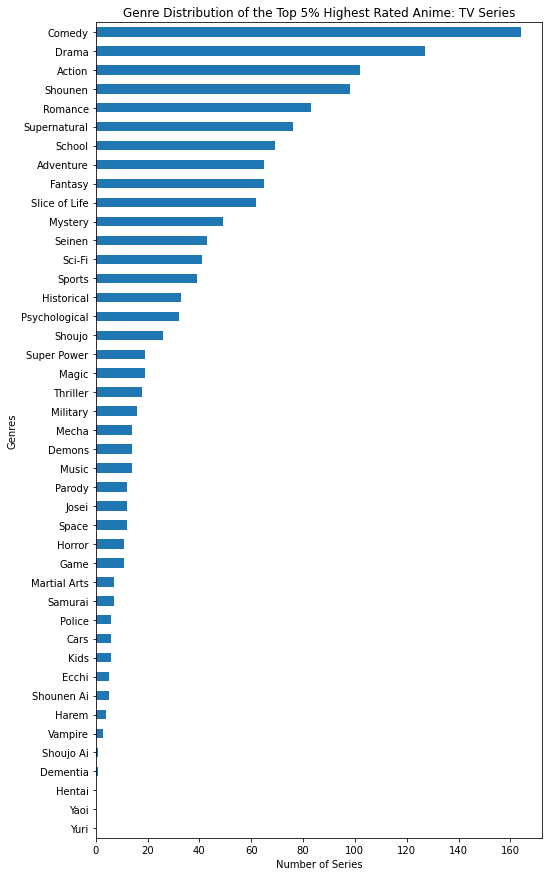

In [25]:
#What does our genre barplot look like now that we're only considering TV series?

top_5_tv = top_5[top_5.type_TV==1]
sum_top_5_tv = top_5_tv.sum(axis=0)
genre_top_5_tv = sum_top_5_tv[col_genre].sort_values(ascending=True)

fig = plt.subplots(figsize=(8,15))
_=genre_top_5_tv.plot(kind='barh')
_=plt.title('Genre Distribution of the Top 5% Highest Rated Anime: TV Series')
_=plt.ylabel('Genres')
_=plt.xlabel('Number of Series')

Our results basically didn't change. We see that Comedy has bit more of a lead over the other genres, but the top 4 are still Comedy, Drama, Action, and Shounen. This time Romance is leading ahead of Adventure at 5th place.

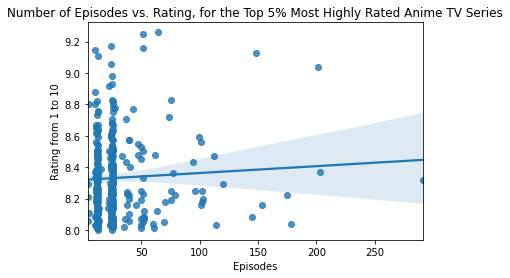

In [26]:
#Look only at the tv series and see the relatioship between episodes and rating.

top_5_tv = top_5[top_5.type_TV==1]

_=sns.regplot(top_5_tv.episodes, top_5_tv.rating)
_=plt.title('Number of Episodes vs. Rating, for the Top 5% Most Highly Rated Anime TV Series')
_=plt.xlabel('Episodes')
_=plt.ylabel('Rating from 1 to 10')

Our seaborn regression plot seems to indicate that more episodes does not necessarily equate to higher rating. Thus, we can aim for the usual 13 or 24 episode series.

Now let's look at the bottom 5% and see what genres to avoid.

### The bottom 5% (Lowest Rated)

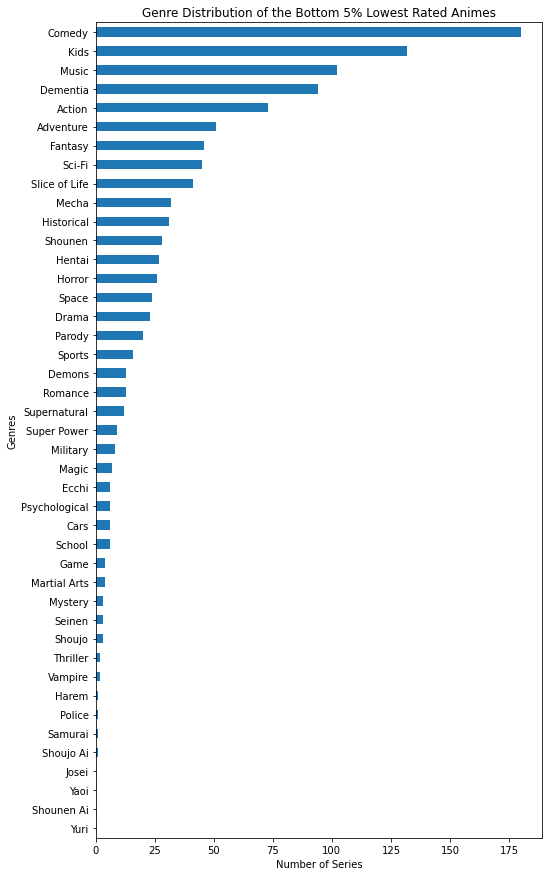

In [27]:
n = 5
anime_sorted = anime_clean.sort_values(by='rating', ascending=True)
bottom_5 = anime_sorted.head(int(len(anime_sorted)*(n/100))).drop(columns=['anime_id','name'])

sum_bottom_5 = bottom_5.sum(axis=0)
genre_bottom_5 = sum_bottom_5[col_genre].sort_values(ascending=True)

fig = plt.subplots(figsize=(8,15))
_=genre_bottom_5.plot(kind='barh')
_=plt.title('Genre Distribution of the Bottom 5% Lowest Rated Animes')
_=plt.ylabel('Genres')
_=plt.xlabel('Number of Series')

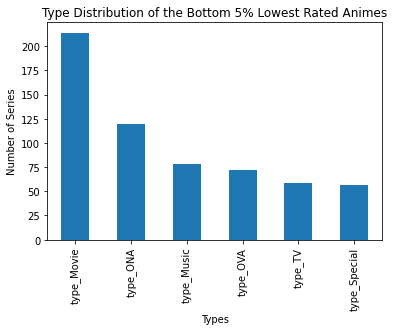

In [28]:
type_bottom_5 = sum_bottom_5[col_type].sort_values(ascending=False)

_=type_bottom_5.plot(kind='bar')
_=plt.title('Type Distribution of the Bottom 5% Lowest Rated Animes')
_=plt.xlabel('Types')
_=plt.ylabel('Number of Series')

Looking at Genre, interestingly Comedy is the number one most common genre. This is probably because Comedy is just a very common genre. The next most common genres are Kids, Music, and Dementia. Luckily those don't overlap with our top genres. We'll make sure to aim for a series that is not for Kids, not Music, and not about Dementia!

Looking at Type, it seems most of the poorly rated animes are anime Movies. Next are ONA (released straight to the internet and not in theatres or TV broadcast), Music, and OVA. Luckily for us, we are aiming for a TV series.

### The top 5% (Most Popular)

Now that we'ved looked at the highest rated animes, let's take a look at the top 5% most popular.

In [29]:
n = 5
anime_sorted = anime_clean.sort_values(by='members', ascending=False)
top_5_pop = anime_sorted.head(int(len(anime_sorted)*(n/100))).drop(columns=['anime_id','name'])

sum_top_5_pop = top_5_pop.sum(axis=0)

#Genre
genre_top_5_pop = sum_top_5_pop[col_genre].sort_values(ascending=True)
#Type
type_top_5_pop = sum_top_5_pop[col_type].sort_values(ascending=False)

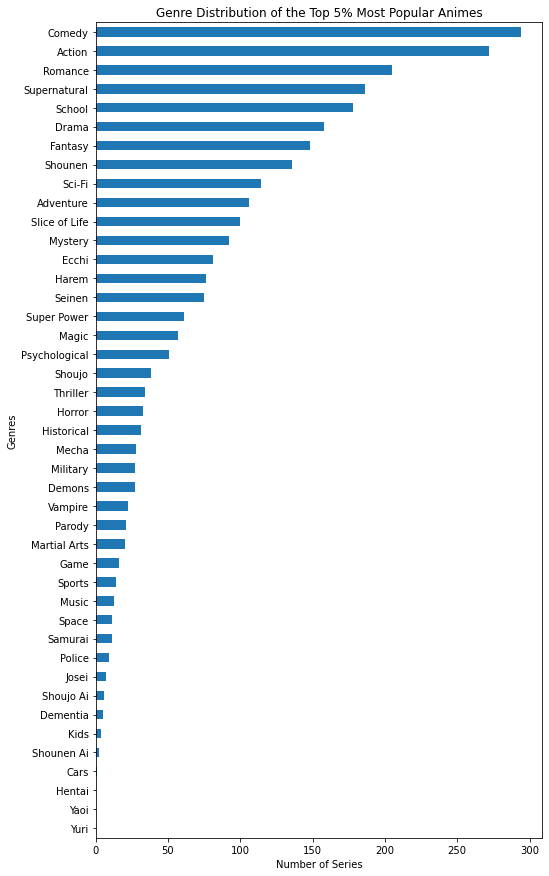

In [30]:
fig = plt.subplots(figsize=(8,15))
_=genre_top_5_pop.plot(kind='barh')
_=plt.title('Genre Distribution of the Top 5% Most Popular Animes')
_=plt.ylabel('Genres')
_=plt.xlabel('Number of Series')

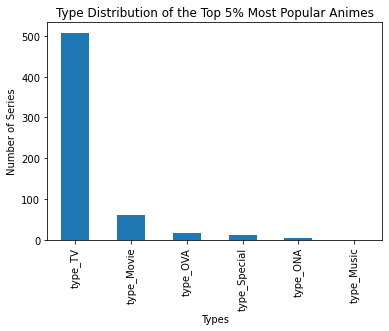

In [31]:
_=type_top_5_pop.plot(kind='bar')
_=plt.title('Type Distribution of the Top 5% Most Popular Animes')
_=plt.xlabel('Types')
_=plt.ylabel('Number of Series')

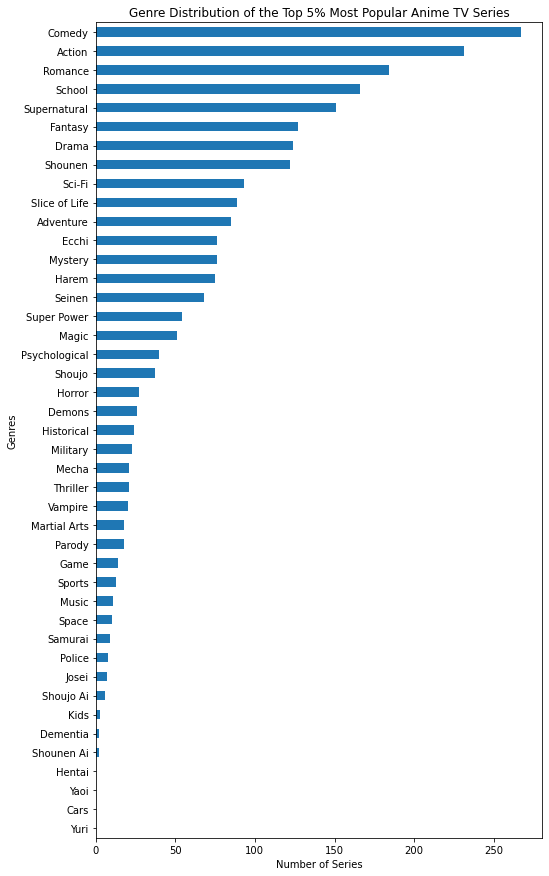

In [32]:
#What does our genre barplot look like if we only consider TV series?

top_5_tv_pop = top_5_pop[top_5_pop.type_TV==1]
sum_top_5_tv_pop = top_5_tv_pop.sum(axis=0)
genre_top_5_tv_pop = sum_top_5_tv_pop[col_genre].sort_values(ascending=True)

fig = plt.subplots(figsize=(8,15))
_=genre_top_5_tv_pop.plot(kind='barh')
_=plt.title('Genre Distribution of the Top 5% Most Popular Anime TV Series')
_=plt.ylabel('Genres')
_=plt.xlabel('Number of Series')

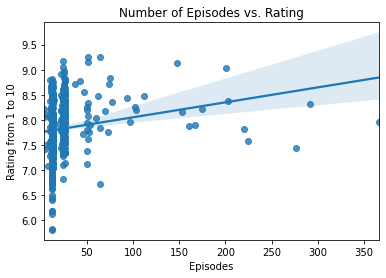

In [33]:
#Look only at the tv series and see the relationship between episodes and rating.

top_5_tv_pop = top_5_pop[top_5_pop.type_TV==1]

_=sns.regplot(top_5_tv_pop.episodes, top_5_tv_pop.rating)
_=plt.title('Number of Episodes vs. Rating')
_=plt.xlabel('Episodes')
_=plt.ylabel('Rating from 1 to 10')

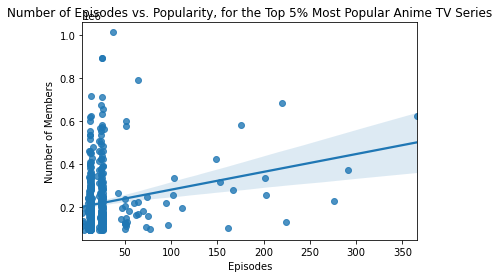

In [34]:
#Look only at the tv series and see the relationship between episodes and popularity.

top_5_tv_pop = top_5_pop[top_5_pop.type_TV==1]

_=sns.regplot(top_5_tv_pop.episodes, top_5_tv_pop.members)
_=plt.title('Number of Episodes vs. Popularity, for the Top 5% Most Popular Anime TV Series')
_=plt.xlabel('Episodes')
_=plt.ylabel('Number of Members')

We see that the most prominent genres for the the most popular animes are: Comedy, Action, Romance, Supernatural, School. When we look only at anime TV series, the positions for Supernatural and School are switched, but the first 3 are the same.

This is different from earlier when we looked at the animes TV series with highest ratings--those genres were: Comedy, Drama, Action, Shounen, and Romance.

The common denominators between these lists are Comedy, Action, and Romance. Perhaps these are the 3 key ingredients to choosing a genre that will be both popular and hopefully have high ratings.

As for the number of episodes, this time we do see a slight positive trend between the number of episodes in a series and its rating and popularity. However, it may be more accurate to say there is no correlation. We should not pay too much attention to episode number.

Let's looka bit more at our total data, and not just the top 5%. At this point, it may be beneficial to see how the proportions of genre differ between our total dataset versus our top 5%. We can easily image this with a pie chart. This will also let us understand what genres dominate the market, and by how much.

In [35]:
#What are the top 10 most popular animes?
anime_sorted = anime.sort_values(by='members', ascending=False)
anime_sorted[['name','genre']].head(10)

,name,genre
40,Death Note,"Mystery, Police, Psychological, Supernatural, ..."
86,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power"
804,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance"
1,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili..."
159,Angel Beats!,"Action, Comedy, Drama, School, Supernatural"
19,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super..."
841,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P..."
3,Steins;Gate,"Sci-Fi, Thriller"
445,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super..."
131,Toradora!,"Comedy, Romance, School, Slice of Life"


Our 10 most popular series on myanimelist.net are:
 * Death Note
 * Shingeki no Kyojin
 * Sword Art Online
 * Fullmetal Alchemist: Brotherhood
 * Angel Beats!
 * Code Geass: Hangyaku no Lelouch
 * Naruto
 * Steins;Gate
 * Mirai Nikki (TV)
 * Toradora!

In [36]:
#Now let's compare genres distribution by pie chart.
anime_sorted = anime_clean.sort_values(by='members', ascending=False) #Use the cleaned df

#Distribution of genres of total dataset
genre_total = anime_sorted[col_genre].sum(axis=0).sort_values(ascending=False)
genre_total_percentage = genre_total/genre_total.sum()
other_genres_total = pd.Series(genre_total_percentage[5:].sum(), index=['Other'])
genre_total_percentage_first_five = genre_total_percentage[0:5].append(other_genres_total)

#Distribution of genres of top 5% most popular TV Series
genre_top_5_tv_pop_percentage = genre_top_5_tv_pop.sort_values(ascending=False)/genre_top_5_tv_pop.sum()
other_genres = pd.Series(genre_top_5_tv_pop_percentage[4:].sum(), index=['Other'])
genre_top_5_tv_pop_percentaged_first_five = genre_top_5_tv_pop_percentage[0:5].append(other_genres)

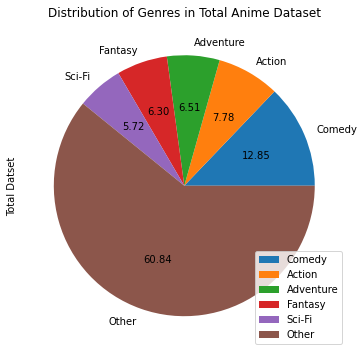

In [37]:
fig = plt.subplots(figsize=(6,6))
_=genre_total_percentage_first_five.plot(kind='pie', autopct='%.2f')
_=plt.legend(loc='lower right')
_=plt.title('Distribution of Genres in Total Anime Dataset')
_=plt.ylabel('Total Datset')

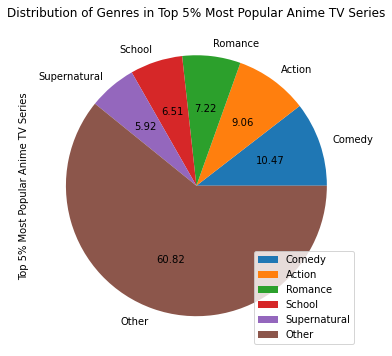

In [38]:
fig = plt.subplots(figsize=(6,6))
_=genre_top_5_tv_pop_percentaged_first_five.plot(kind='pie', autopct='%.2f')
_=plt.legend(loc='lower right')
_=plt.title('Distribution of Genres in Top 5% Most Popular Anime TV Series')
_=plt.ylabel('Top 5% Most Popular Anime TV Series')

This gives us a slightly clearer view that in the total dataset, there are quite a few Adventure, Fantasy, and Sci-Fi series. But in the Top 5% Most Popular, we instead have Romance, Schoo, and Supernatural.

### The bottom 5% (Least Popular)

Let's look at what genres are most common in the least popular animes, and therefore see what to avoid.

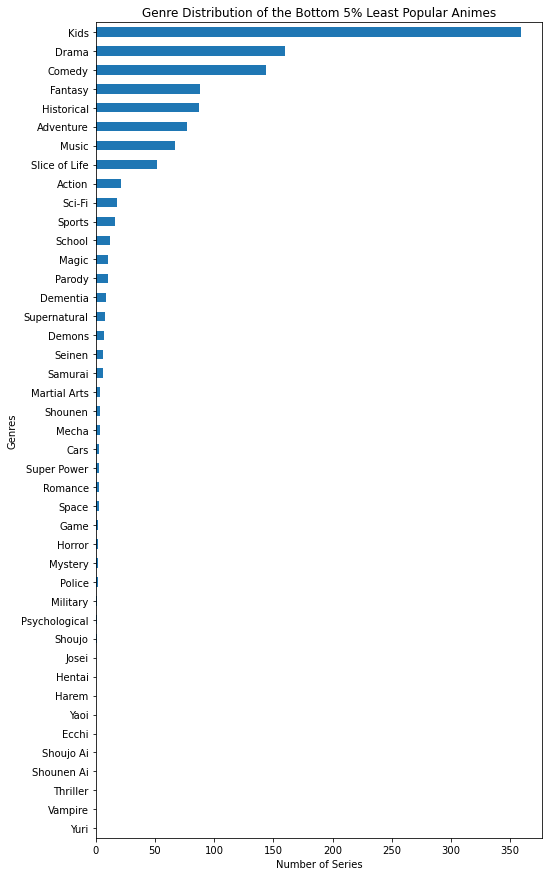

In [39]:
n = 5
anime_sorted_pop = anime_clean.sort_values(by='members', ascending=True)
bottom_5_pop = anime_sorted_pop.head(int(len(anime_sorted)*(n/100))).drop(columns=['anime_id','name'])

sum_bottom_5_pop = bottom_5_pop.sum(axis=0)
genre_bottom_5_pop = sum_bottom_5_pop[col_genre].sort_values(ascending=True)

fig = plt.subplots(figsize=(8,15))
_=genre_bottom_5_pop.plot(kind='barh')
_=plt.title('Genre Distribution of the Bottom 5% Least Popular Animes')
_=plt.ylabel('Genres')
_=plt.xlabel('Number of Series')

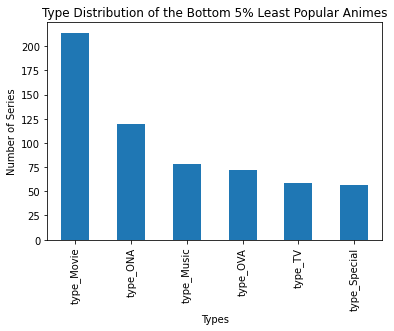

In [40]:
type_bottom_5_pop = sum_bottom_5_pop[col_type].sort_values(ascending=False)

_=type_bottom_5.plot(kind='bar')
_=plt.title('Type Distribution of the Bottom 5% Least Popular Animes')
_=plt.xlabel('Types')
_=plt.ylabel('Number of Series')

As before when we looked at the lowest rated animes, we again see here that Movies, ONA, Music, and OVA perform poorly. 

Kids, Drama, and Comedy are the 3 most common genres of the least popular animes, with Kids far outpacing the other genre columns. Comedy is among the list of genres of the most popular and most highly rated anime, so this could amount to simply being a very common genre. As for Kids, it is possible that children aren't able to make accounts and therefore aren't able to become members on myanimelist.net of the animes targeted for them. 

## Conclusion

If we want to make something popular and highly rated, we want to make a TV Series as opposed to a Movie, OVA, ONA, Music video, or Special.

We don't have to worry about the length of the series. Depending on our budget and the story we want to tell, we should aim for a 1-cour (10-13 episodes) or 2-cour (24 episodes) series.

We've found the following genres to be most prominent:
 * For the most highly rated anime
   * Comedy
   * Drama
   * Action
   * Shounen
   * Romance
 * For the most popular anime
   * Comedy
   * Action
   * Romance
   * Supernatural
   * School
 * For the lowest rated anime
   * Comedy
   * Kids
   * Music
   * Dementia
 * For the least popular anime
   * Kids
   * Drama
   * Comedy

The common denominators between these lists are Comedy, Action, and Romance. These may be the 3 key ingredients to choosing a genre that will be both popular and hopefully have high ratings.

### Future Ideas

Since the goal of this assignment was to tell a story with Data, we didn't do any modeling and didn't use our no_rating or has_rating df's. In some future project, we could try to do a KNN, RF classifier, or other model to function as a recommendations algorithm and predict what kind of users would rate which animes highly.